In [1]:
import time
import os

import gymnasium as gym
import numpy as np

#from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import SAC
from stable_baselines3 import TD3
from stable_baselines3.common import results_plotter
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback, EveryNTimesteps
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback


libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen


In [2]:
os.environ# Set the environment variable
os.environ['CUDA_VISIBLE_DEVICES'] = 'MIG-73000f9d-03d4-5dab-ad23-34b546569bdd'

# Now you can run shell commands that will pick up this environment
!nvidia-smi

Tue Oct 24 15:52:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:01:00.0 Off |                   On |
| N/A   39C    P0    46W / 300W |     48MiB / 81920MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:C4:00.0 Off |                   On |
| N/A   

In [3]:
import torch
# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of CUDA devices
    num_devices = torch.cuda.device_count()
    print(f'Number of CUDA devices: {num_devices}')

    # List all CUDA devices
    for i in range(num_devices):
        device = torch.cuda.get_device_name(i)
        print(f'Device {i}: {device}')
else:
    print('CUDA is not available.')

Number of CUDA devices: 1
Device 0: NVIDIA A100 80GB PCIe MIG 1g.10gb


In [4]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf
        self.n_calls = 0

    def _on_step(self) -> bool:
        self.n_calls += 1
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")
                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)
        return True


In [5]:
log_dir = '../SAC+HER_Multi-Task_Fetch-Obstacle-PickAndPlace_32-MPI_FIXED-TUNED-32-Experiment02'
env_id = 'FetchObstaclePickAndPlace-v2'
num_cpu = 32

vec_env = make_vec_env(env_id, n_envs=num_cpu, monitor_dir=log_dir, vec_env_cls=SubprocVecEnv, seed=9160)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
#model = A2C("MlpPolicy", vec_env, verbose=0)

libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen
libEGL warning: egl: failed to create dri2 screen


In [7]:
from stable_baselines3 import HerReplayBuffer, DDPG, DQN, SAC, TD3
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from stable_baselines3.common.envs import BitFlippingEnv

model_class = SAC  # works also with SAC, DDPG and TD3
N_BITS = 15

#env = env_creator({})#BitFlippingEnv(n_bits=N_BITS, continuous=model_class in [DDPG, SAC, TD3], max_steps=N_BITS)

# Available strategies (cf paper): future, final, episode
goal_selection_strategy = "future" # equivalent to GoalSelectionStrategy.FUTURE

# Initialize the model
model = model_class(
    "MultiInputPolicy",
    vec_env,
    replay_buffer_class=HerReplayBuffer,
    # Parameters for HER
    replay_buffer_kwargs=dict(
        #n_envs=4,
        n_sampled_goal=8,
        goal_selection_strategy=goal_selection_strategy,
    ),
    buffer_size=2000000,
    learning_starts=7000,
    batch_size=512,
    verbose=0,
    learning_rate=0.001,
    #action_noise
    tensorboard_log="../R3L-LOGS/SAC+HER_Multi-Task_Fetch-Obstacle-PickAndPlace_32-MPI_FIXED-TUNED-32-Experiment02"
)

# Train the model
model.learn(60_000_000, callback=callback)

model.save("./SAC+HER_Multi-Task_Fetch-Obstacle-PickAndPlace_32-MPI_FIXED-TUNED-32-Experiment02")
# Because it needs access to `env.compute_reward()`
# HER must be loaded with the env
model = model_class.load("./SAC+HER_Multi-Task_Fetch-Obstacle-PickAndPlace_32-MPI_FIXED-TUNED-32-Experiment02", env=env)

obs, info = env.reset()
for _ in range(100):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        obs, info = env.reset()

/home/lunet/cocp5/anaconda3/envs/R3L-server84/lib/python3.9/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.compute_reward` for environment variables or `env.get_attr('compute_reward')` that will search the reminding wrappers.
  logger.warn(


Num timesteps: 16000
Best mean reward: -inf - Last mean reward per episode: -47.50
Saving new best model to ../SAC+HER_Multi-Task_Fetch-Obstacle-PickAndPlace_32-MPI_FIXED-TUNED-32-Experiment02/best_model.zip
Num timesteps: 32000
Best mean reward: -47.50 - Last mean reward per episode: -49.43
Num timesteps: 48000
Best mean reward: -47.50 - Last mean reward per episode: -47.50
Num timesteps: 64000
Best mean reward: -47.50 - Last mean reward per episode: -48.50
Num timesteps: 80000
Best mean reward: -47.50 - Last mean reward per episode: -47.50
Num timesteps: 96000
Best mean reward: -47.50 - Last mean reward per episode: -47.50
Num timesteps: 112000
Best mean reward: -47.50 - Last mean reward per episode: -48.50
Num timesteps: 128000
Best mean reward: -47.50 - Last mean reward per episode: -47.50
Num timesteps: 144000
Best mean reward: -47.50 - Last mean reward per episode: -48.50
Num timesteps: 160000
Best mean reward: -47.50 - Last mean reward per episode: -48.00
Num timesteps: 176000
B

NameError: name 'env' is not defined

In [ ]:
model.learn(500000)

In [ ]:
from stable_baselines3 import HerReplayBuffer, DDPG, DQN, SAC, TD3
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from stable_baselines3.common.envs import BitFlippingEnv
model_class = SAC


In [ ]:
import gymnasium as gym
#from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

class RenderOneEnvWrapper(gym.Wrapper):
    def __init__(self, env, env_idx, render_idx):
        super(RenderOneEnvWrapper, self).__init__(env)
        self.env_idx = env_idx
        self.render_idx = render_idx

    def render(self):
        if self.env_idx == self.render_idx:
            return self.env.render()
        return None


def make_env(env_id: str, rank: int, render_idx: int, seed: int = 0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environment you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    :return: (Callable)
    """

    def _init() -> gym.Env:
        env = gym.make(env_id, render_mode='rgb_array', reward_type='sparse', max_episode_steps=50)
        env.reset(seed=seed + rank)
        env = RenderOneEnvWrapper(env, rank, render_idx)
        return env

    set_random_seed(seed)
    return _init

env_id = "FetchObstaclePickAndPlace-v2"
num_envs = 32
render_idx = 0  # Index of the environment you want to render

envs = [make_env(env_id, i, render_idx) for i in range(num_envs)]
vec_env = SubprocVecEnv(envs)

# This will render only the environment with index `render_idx`
vec_env.render()


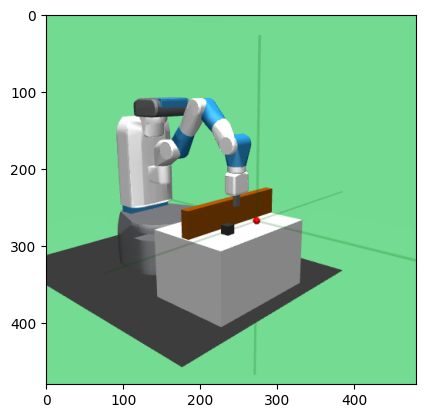

In [10]:
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

# Get the first environment from the vectorized environments
single_env = env = gym.make(env_id, render_mode='rgb_array', reward_type='sparse', max_episode_steps=50)#vec_env#.envs[0]
model = model_class.load("/home/lunet/cocp5/R3L/SAC+HER_Multi-Task_Fetch-Obstacle-PickAndPlace_32-MPI_FIXED-TUNED-32-Experiment02/best_model", env=env)
obs, info = single_env.reset()

img = plt.imshow(single_env.render())


for _ in range(500):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = single_env.step(action)
    if terminated or truncated:
        obs, info = single_env.reset()
    img.set_data(single_env.render()) # Just update the data
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)
